In [46]:
import pandas as pd

sdel=pd.read_excel("Сделки_2025-11-25.xlsx")
proj=pd.read_excel("Проектные данные_2025-11-25.xlsx")

In [47]:
import pandas as pd
import numpy as np

# === НАСТРОЙКИ ===
IQR_THRESHOLD = 1.5
MIN_PRICE_UNIT = 1_000_000

# === 0. ПОДГОТОВКА И БЕЗОПАСНОЕ ОБЪЕДИНЕНИЕ (ЧТОБЫ НАЙТИ ДАТУ СТАРТА) ===
sdel_clean = sdel.copy()
proj_clean = proj.copy()

# Названия колонок с датами, которые нам нужны
col_dogovor = 'Дата договора (месяц.год)'
col_reg = 'Дата регистрации (месяц.год)'
col_start = 'Дата начала проекта' # <--- ПРОВЕРЬ, ЧТО В ТАБЛИЦЕ PROJ ОНА НАЗЫВАЕТСЯ ТАК ЖЕ!

# Пытаемся найти дату старта. Если её нет в сделках, тащим из проектов
if col_start not in sdel_clean.columns:
    if col_start in proj_clean.columns:
        # Ищем ключ для объединения (обычно это ID проекта)
        # Пробуем самые частые варианты: 'ID проекта', 'id_project', 'ID_PROJ'
        merge_keys = [k for k in ['ID проекта', 'ID_проекта', 'id_project'] if k in sdel_clean.columns and k in proj_clean.columns]
        
        if merge_keys:
            print(f"✅ Подтягиваем '{col_start}' из таблицы проектов по ключу: {merge_keys[0]}...")
            sdel_clean = sdel_clean.merge(proj_clean[[merge_keys[0], col_start]], on=merge_keys[0], how='left')
        else:
            print(f"⚠️ ВНИМАНИЕ: Не нашел общий ID для объединения таблиц. '{col_start}' может отсутствовать!")
    else:
        print(f"⚠️ ВНИМАНИЕ: Колонки '{col_start}' нет ни в сделках, ни в проектах. Проверь название!")

# === 1. ПРЕДОБРАБОТКА (ETL) ===
def clean_numeric_col(df, col_name):
    if col_name in df.columns:
        val = df[col_name].astype(str)
        val = val.str.replace("\u00a0", "").str.replace(" ", "").str.replace(",", ".")
        return pd.to_numeric(val, errors="coerce").fillna(0)
    return df[col_name] if col_name in df.columns else 0

# Очистка чисел
target_cols = ['Сумма бюджета', 'Суммарная площадь сделок', 'Суммарное количество сделок', 
               'Этаж лота', 'Количество комнат']
for col in target_cols:
    sdel_clean[col] = clean_numeric_col(sdel_clean, col)

# === ОЧИСТКА ДАТ (САМОЕ ВАЖНОЕ) ===
# Собираем все даты, которые есть в датафрейме
all_date_cols = [c for c in [col_dogovor, col_reg, col_start] if c in sdel_clean.columns]

print("\n=== ОТЧЕТ ПО ДАТАМ (ДО ФИЛЬТРАЦИИ) ===")
for col in all_date_cols:
    # 1. Запоминаем сколько было пустых до конвертации
    na_before = sdel_clean[col].isna().sum()
    
    # 2. Конвертируем с dayfirst=True (Российский формат ДД.ММ.ГГГГ)
    # errors='coerce' превратит мусор в NaT, но мы это отследим
    sdel_clean[col] = pd.to_datetime(sdel_clean[col], dayfirst=True, errors='coerce')
    
    # 3. Считаем сколько стало пустых
    na_after = sdel_clean[col].isna().sum()
    lost = na_after - na_before
    
    print(f"Колонка '{col}':")
    if lost > 0:
        print(f"  ❌ БИТЫЙ ФОРМАТ: {lost} значений не удалось прочитать (превратились в NaT).")
    else:
        print(f"  ✅ Все значения успешно распознаны.")

# Расчет удельных метрик
sdel_clean['cnt_safe'] = sdel_clean['Суммарное количество сделок'].replace(0, 1)
sdel_clean['Unit_Area'] = sdel_clean['Суммарная площадь сделок'] / sdel_clean['cnt_safe']
sdel_clean['Unit_Price'] = sdel_clean['Сумма бюджета'] / sdel_clean['cnt_safe']
sdel_clean['Price_m2'] = sdel_clean['Сумма бюджета'] / sdel_clean['Суммарная площадь сделок'].replace(0, np.nan)


# === 2. УМНАЯ ФИЛЬТРАЦИЯ: ПЛОЩАДЬ vs КОМНАТЫ ===
mask_area_rooms_outlier = pd.Series(False, index=sdel_clean.index)
unique_rooms = sorted(sdel_clean['Количество комнат'].unique())

print("\n=== ФИЛЬТРАЦИЯ ПЛОЩАДЕЙ ===")
for room_cnt in unique_rooms:
    idx_room = sdel_clean[sdel_clean['Количество комнат'] == room_cnt].index
    if len(idx_room) == 0: continue
    
    subset_areas = sdel_clean.loc[idx_room, 'Unit_Area']
    Q1 = subset_areas.quantile(0.25)
    Q3 = subset_areas.quantile(0.75)
    IQR = Q3 - Q1
    lower = max(Q1 - (IQR_THRESHOLD * IQR), 10.0)
    upper = Q3 + (IQR_THRESHOLD * IQR)
    
    bad_indices = subset_areas[(subset_areas < lower) | (subset_areas > upper)].index
    mask_area_rooms_outlier.loc[bad_indices] = True

# === 3. ОСТАЛЬНЫЕ ФИЛЬТРЫ ===
Q1_p = sdel_clean['Price_m2'].quantile(0.25)
Q3_p = sdel_clean['Price_m2'].quantile(0.75)
IQR_p = Q3_p - Q1_p
mask_price_outlier = (sdel_clean['Price_m2'] < (Q1_p - 1.5*IQR_p)) | (sdel_clean['Price_m2'] > (Q3_p + 1.5*IQR_p))

mask_cheap = sdel_clean['Unit_Price'] < MIN_PRICE_UNIT

# === 4. СБОРКА ИТОГОВОГО ДАТАСЕТА ===
total_mask = mask_area_rooms_outlier | mask_price_outlier | mask_cheap 
sdel_final = sdel_clean[~total_mask].copy()

# === 5. ФИНАЛЬНЫЙ ОТЧЕТ ===
print("\n" + "="*60)
print(f"ИТОГИ ОЧИСТКИ (Было: {len(sdel_clean)} -> Стало: {len(sdel_final)})")
print("-" * 60)
    
print("-" * 60)
print(f"Удалено строк всего: {total_mask.sum()}")
sdel_final.drop(columns=['cnt_safe'], inplace=True, errors='ignore')

⚠️ ВНИМАНИЕ: Колонки 'Дата начала проекта' нет ни в сделках, ни в проектах. Проверь название!

=== ОТЧЕТ ПО ДАТАМ (ДО ФИЛЬТРАЦИИ) ===
Колонка 'Дата договора (месяц.год)':
  ✅ Все значения успешно распознаны.
Колонка 'Дата регистрации (месяц.год)':
  ✅ Все значения успешно распознаны.

=== ФИЛЬТРАЦИЯ ПЛОЩАДЕЙ ===

ИТОГИ ОЧИСТКИ (Было: 50955 -> Стало: 47983)
------------------------------------------------------------
------------------------------------------------------------
Удалено строк всего: 2972


In [48]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

def process_real_estate_data(
    proj, 
    deals, 
    bank_percentile_range: tuple = (0, 100),
    bank_metric_for_filtering: str = 'sq_meters' # 'count', 'sq_meters', 'money'
):
    """
    Основная функция ETL для подготовки данных.
    
    МОДИФИКАЦИЯ: 
    Расчет Sellout (Sold_Area) теперь производится СТРОГО ПО ИПОТЕЧНЫМ СДЕЛКАМ,
    чтобы соответствовать логике анализа ипотечного покрытия (как в Script A).
    
    Параметры:
    ----------
    path_proj : str - путь к файлу проектов
    path_deals : str - путь к файлу сделок
    bank_percentile_range : tuple - (min_p, max_p). Пример (25, 75).
    bank_metric_for_filtering : str - метрика для фильтрации банков.
    
    Возвращает:
    ----------
    df_ml : pd.DataFrame - итоговый датасет
    bank_stats : pd.DataFrame - статистика по банкам
    report : dict - технические метрики
    """
    
    print(f"🚀 ЗАПУСК ОБРАБОТКИ ДАННЫХ (РЕЖИМ: ИПОТЕЧНЫЙ SELLOUT)")
    print(f"   Фильтрация банков-фичей: процентили {bank_percentile_range}, метрика '{bank_metric_for_filtering}'")
    
    # ==========================================
    # 1. ЗАГРУЗКА И ОЧИСТКА ЧИСЕЛ
    # ==========================================
    def clean_numeric_col(df, col_name):
        if col_name in df.columns:
            val = df[col_name].astype(str)
            val = val.str.replace("\u00a0", "").str.replace(" ", "").str.replace(",", ".")
            return pd.to_numeric(val, errors="coerce").fillna(0)
        return df[col_name] if col_name in df.columns else 0

    # Очистка площадей
    for col in ["Общая проектная площадь", "Суммарная площадь сделок", 
                "Суммарное количество сделок", "Суммарная стоимость сделок"]:
        if col in proj.columns: proj[col] = clean_numeric_col(proj, col)
        if col in deals.columns: deals[col] = clean_numeric_col(deals, col)
    
    if "Суммарное количество сделок" not in deals.columns:
        deals["Суммарное количество сделок"] = 1
    
    # Очистка дат
    deals["dt_deal"] = pd.to_datetime(deals["Дата договора (месяц.год)"], dayfirst=True, errors="coerce")
    mask_date_na = deals["dt_deal"].isna()
    if mask_date_na.any():
        deals.loc[mask_date_na, "dt_deal"] = pd.to_datetime(
            "01." + deals.loc[mask_date_na, "Дата договора (месяц.год)"].astype(str), 
            dayfirst=True, errors="coerce"
        )
    deals = deals.dropna(subset=["dt_deal"])

    # Очистка ID и Проектов
    for df in [proj, deals]:
        df['ID корпуса'] = df['ID корпуса'].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()
        if "Проект" in df.columns: df["Проект"] = df["Проект"].astype(str).str.strip()

    # Мэппинг проектов
    corpus_map = proj[["ID корпуса", "Проект", "Класс проекта"]].drop_duplicates().set_index("ID корпуса")
    deals = deals.merge(corpus_map, on="ID корпуса", how="left")
    if "Проект_y" in deals.columns:
        deals["Проект"] = deals["Проект_y"].fillna(deals["Проект_x"])
    deals = deals.dropna(subset=["Проект"])
    
    # Список значений, обозначающих ипотеку (для фильтрации)
    mortgage_flags = ['да', 'yes', 'true', '1', 'ипотека']

    # ==========================================
    # 2. АНАЛИЗ БАНКОВ И РАСЧЕТ ВЕСОВ
    # ==========================================
    print("\n🏦 АНАЛИЗ БАНКОВСКОГО СЕКТОРА...")
    
    if "Название банка" not in deals.columns:
        deals["Название банка"] = "Не указан"
    deals["Название банка"] = deals["Название банка"].fillna("Рассрочка/Кэш").astype(str).str.strip()
    
    # Для статистики банков берем ВСЕ сделки (чтобы понимать общий объем рынка)
    # Но если мы хотим анализировать именно ИПОТЕЧНЫХ игроков, можно отфильтровать deals перед groupby.
    # В данном случае оставляем логику Script B: смотрим все сделки, где указан банк.
    
    grp_cols = {"Суммарное количество сделок": "sum", "Суммарная площадь сделок": "sum"}
    if "Суммарная стоимость сделок" in deals.columns:
        grp_cols["Суммарная стоимость сделок"] = "sum"
        
    bank_stats = deals.groupby("Название банка").agg(grp_cols).reset_index()
    
    rename_map = {
        "Суммарное количество сделок": "count",
        "Суммарная площадь сделок": "sq_meters",
        "Суммарная стоимость сделок": "money"
    }
    bank_stats = bank_stats.rename(columns=rename_map)
    if "money" not in bank_stats.columns: bank_stats["money"] = 0
    
    total_sq = bank_stats["sq_meters"].sum()
    bank_stats["share_sq_meters"] = (bank_stats["sq_meters"] / total_sq * 100)
    
    target_metric = bank_metric_for_filtering if bank_metric_for_filtering in bank_stats.columns else 'sq_meters'
    
    threshold_low = np.percentile(bank_stats[target_metric], bank_percentile_range[0])
    threshold_high = np.percentile(bank_stats[target_metric], bank_percentile_range[1])
    
    bank_stats["is_selected"] = (bank_stats[target_metric] >= threshold_low) & \
                                (bank_stats[target_metric] <= threshold_high)
    
    bank_stats["bank_weight_score"] = np.log1p(bank_stats["sq_meters"])
    
    selected_banks = bank_stats[bank_stats["is_selected"]]["Название банка"].tolist()
    bank_weights_dict = bank_stats.set_index("Название банка")["bank_weight_score"].to_dict()
    
    print(f"   Всего уникальных банков: {len(bank_stats)}")
    print(f"   Отобрано банков (диапазон {bank_percentile_range}%): {len(selected_banks)}")

    # ==========================================
    # 3. МАКРО-ДАННЫЕ
    # ==========================================
    key_rate_data = [
        ('2013-09-13', '2014-03-02', 5.50), ('2014-03-03', '2014-04-24', 7.00), ('2014-04-25', '2014-07-27', 7.50),
        ('2014-07-28', '2014-11-04', 8.00), ('2014-11-05', '2014-12-11', 9.50), ('2014-12-12', '2014-12-15', 10.50),
        ('2014-12-16', '2015-02-01', 17.00), ('2015-02-02', '2015-03-15', 15.00), ('2015-03-16', '2015-05-04', 14.00),
        ('2015-05-05', '2015-06-15', 12.50), ('2015-06-16', '2015-08-02', 11.50), ('2015-08-03', '2016-06-13', 11.00),
        ('2016-06-14', '2016-09-18', 10.50), ('2016-09-19', '2017-03-26', 10.00), ('2017-03-27', '2017-05-01', 9.75),
        ('2017-05-02', '2017-06-18', 9.25), ('2017-06-19', '2017-09-17', 9.00), ('2017-09-18', '2017-10-29', 8.50),
        ('2017-10-30', '2017-12-17', 8.25), ('2017-12-18', '2018-02-11', 7.75), ('2018-02-12', '2018-03-25', 7.50),
        ('2018-03-26', '2018-09-16', 7.25), ('2018-09-17', '2018-12-16', 7.50), ('2018-12-17', '2019-06-16', 7.75),
        ('2019-06-17', '2019-07-28', 7.50), ('2019-07-29', '2019-09-08', 7.25), ('2019-09-09', '2019-10-27', 7.00),
        ('2019-10-28', '2019-12-15', 6.50), ('2019-12-16', '2020-02-09', 6.25), ('2020-02-10', '2020-04-26', 6.00),
        ('2020-04-27', '2020-06-21', 5.50), ('2020-06-22', '2020-07-26', 4.50), ('2020-07-27', '2021-03-21', 4.25),
        ('2021-03-22', '2021-04-25', 4.50), ('2021-04-26', '2021-06-14', 5.00), ('2021-06-15', '2021-07-25', 5.50),
        ('2021-07-26', '2021-09-12', 6.50), ('2021-09-13', '2021-10-24', 6.75), ('2021-10-25', '2021-12-19', 7.50),
        ('2021-12-20', '2022-02-13', 8.50), ('2022-02-14', '2022-02-27', 9.50), ('2022-02-28', '2022-04-10', 20.00),
        ('2022-04-11', '2022-05-03', 17.00), ('2022-05-04', '2022-05-26', 14.00), ('2022-05-27', '2022-06-13', 11.00),
        ('2022-06-14', '2022-07-24', 9.50), ('2022-07-25', '2022-09-18', 8.00), ('2022-09-19', '2022-12-31', 7.50),
        ('2023-01-01', '2023-07-26', 7.5), ('2023-07-27', '2023-08-14', 8.5), ('2023-08-15', '2023-09-17', 12.0),
        ('2023-09-18', '2023-10-29', 13.0), ('2023-10-30', '2023-12-17', 15.0), ('2023-12-18', '2024-07-28', 16.0),
        ('2024-07-29', '2024-09-15', 18.0), ('2024-09-16', '2024-12-27', 19.0), ('2024-12-28', '2025-06-08', 21.0)
    ]
    macro_range = pd.date_range(start='2013-09-13', end='2026-01-01', freq='D')
    macro_df = pd.DataFrame(index=macro_range)
    macro_df['key_rate'] = np.nan
    macro_df['is_subsidy'] = 0

    for start, end, rate in key_rate_data:
        mask = (macro_df.index >= pd.to_datetime(start)) & (macro_df.index <= pd.to_datetime(end))
        macro_df.loc[mask, 'key_rate'] = rate

    macro_df['key_rate'] = macro_df['key_rate'].ffill()
    macro_df.loc[(macro_df.index >= '2020-04-17') & (macro_df.index < '2024-07-01'), 'is_subsidy'] = 1
    macro_monthly = macro_df['key_rate'].resample('MS').mean()

    def get_macro_features(start_date, end_date):
        subset_daily = macro_df[(macro_df.index >= start_date) & (macro_df.index <= end_date)]
        if subset_daily.empty: return np.nan, np.nan, 0, np.nan
        kr_start = subset_daily['key_rate'].iloc[0]
        kr_spread = subset_daily['key_rate'].max() - subset_daily['key_rate'].min()
        sub_share = subset_daily['is_subsidy'].mean()
        subset_monthly = macro_monthly[(macro_monthly.index >= start_date) & (macro_monthly.index <= end_date)]
        kr_mean_monthly = subset_daily['key_rate'].mean() if subset_monthly.empty else subset_monthly.mean()
        return kr_start, kr_spread, sub_share, kr_mean_monthly

    # ==========================================
    # 4. СБОРКА ДАТАСЕТА (MAIN LOOP)
    # ==========================================
    corpus_starts = deals.groupby("ID корпуса")["dt_deal"].min().reset_index().rename(columns={"dt_deal": "corpus_start"})
    proj = proj.merge(corpus_starts, on="ID корпуса", how="left")
    
    temp_proj_starts = proj.groupby("Проект")["corpus_start"].min().reset_index().rename(columns={"corpus_start": "project_start_implied"})
    proj = proj.merge(temp_proj_starts, on="Проект", how="left")
    proj["corpus_start"] = proj["corpus_start"].fillna(proj["project_start_implied"])
    
    proj_starts = proj.groupby("Проект")["corpus_start"].min().reset_index().rename(columns={"corpus_start": "project_start"})
    MAX_DATE = deals["dt_deal"].max()
    
    data_list = []
    projects_list = proj_starts["Проект"].unique()
    
    stats_cnt = {"total": len(projects_list), "success": 0, "skipped_young": 0, "skipped_no_sales": 0, "dropped_bad_so": 0}

    print(f"\n🔄 ОБРАБОТКА ПРОЕКТОВ ({len(projects_list)} шт)...")

    for project in projects_list:
        t0 = proj_starts.loc[proj_starts["Проект"] == project, "project_start"].values[0]
        t0 = pd.to_datetime(t0)
        if pd.isna(t0): continue
        
        p_class = proj[proj["Проект"] == project]["Класс проекта"].iloc[0]
        
        # --- ГОД 1 ---
        t_end_y1 = t0 + timedelta(days=365)
        
        if (MAX_DATE - t0).days < 365:
            stats_cnt["skipped_young"] += 1
            continue

        # ПЛОЩАДЬ (Знаменатель)
        valid_corp_y1 = proj[(proj["Проект"] == project) & (proj["corpus_start"] <= t_end_y1)]
        area_planned_y1 = valid_corp_y1["Общая проектная площадь"].sum()
        
        # СДЕЛКИ (Числитель) - ТЕПЕРЬ СЧИТАЕМ ТОЛЬКО ИПОТЕЧНЫЕ СДЕЛКИ
        mask_sales_y1 = (deals["Проект"] == project) & (deals["dt_deal"] >= t0) & (deals["dt_deal"] <= t_end_y1)
        deals_subset_y1 = deals[mask_sales_y1]
        
        # Фильтр: Только ипотечные сделки для расчета Sellout
        mortgage_deals_y1 = deals_subset_y1[deals_subset_y1["Ипотека"].astype(str).str.lower().isin(mortgage_flags)]
        
        # ВАЖНО: sales_y1 теперь = площадь ипотечных сделок (как в Script A)
        sales_y1 = mortgage_deals_y1["Суммарная площадь сделок"].sum()
        
        # Если проект вообще не продавался в ипотеку или нет площади - пропускаем (или ставим 0, но лучше пропустить)
        if sales_y1 <= 0 or area_planned_y1 <= 0:
            stats_cnt["skipped_no_sales"] += 1
            continue

        # МАКРО
        kr_start, kr_spread, sub_share, kr_mean = get_macro_features(t0, t_end_y1)
        
        # ДОП. МЕТРИКИ (Доля ипотеки от всех сделок)
        # Считаем относительно всего объема сделок (deals_subset_y1), а не только ипотечных
        mort_share = len(mortgage_deals_y1) / len(deals_subset_y1) if len(deals_subset_y1) > 0 else 0
        
        # ФИЧИ БАНКОВ (Считаем на основе ипотечной подвыборки)
        banks_in_project = mortgage_deals_y1[mortgage_deals_y1["Название банка"].isin(selected_banks)]["Название банка"].unique()
        
        num_banks_filtered = len(banks_in_project)
        bank_weighted_index = sum([bank_weights_dict.get(b, 0) for b in banks_in_project])

        so_val = (sales_y1 / area_planned_y1) * 100
        
        data_list.append({
            "Project": project,
            "Class": p_class,
            "Year_Num": 1,
            "Planned_Area": area_planned_y1,
            "Sold_Area": sales_y1, # Это Mortgage Sold Area
            "Sellout": so_val,     # Это Mortgage Sellout
            "KR_Start": kr_start,
            "KR_Spread": kr_spread,
            "KR_Mean": kr_mean,
            "Subsidy_Share": sub_share,
            "Mortgage_Share": mort_share,
            "Num_Banks_Filtered": num_banks_filtered,
            "Bank_Index_Weighted": bank_weighted_index,
            "Log_Area": np.log1p(area_planned_y1)
        })

        # --- ГОД 2 ---
        t_start_y2 = t_end_y1 + timedelta(days=1)
        t_end_y2 = t0 + timedelta(days=730)
        
        if (MAX_DATE - t0).days >= 730:
            valid_corp_y2 = proj[(proj["Проект"] == project) & (proj["corpus_start"] <= t_end_y2)]
            area_planned_y2 = valid_corp_y2["Общая проектная площадь"].sum()
            
            mask_sales_y2 = (deals["Проект"] == project) & (deals["dt_deal"] >= t_start_y2) & (deals["dt_deal"] <= t_end_y2)
            deals_subset_y2 = deals[mask_sales_y2]
            
            # Фильтр: Только ипотечные сделки для расчета Sellout (Год 2)
            mortgage_deals_y2 = deals_subset_y2[deals_subset_y2["Ипотека"].astype(str).str.lower().isin(mortgage_flags)]
            sales_y2 = mortgage_deals_y2["Суммарная площадь сделок"].sum()
            
            kr_start_2, kr_spread_2, sub_share_2, kr_mean_2 = get_macro_features(t_start_y2, t_end_y2)
            
            mort_share_2 = len(mortgage_deals_y2) / len(deals_subset_y2) if len(deals_subset_y2) > 0 else 0
            
            banks_in_project_2 = mortgage_deals_y2[mortgage_deals_y2["Название банка"].isin(selected_banks)]["Название банка"].unique()
            bank_weighted_index_2 = sum([bank_weights_dict.get(b, 0) for b in banks_in_project_2])

            if area_planned_y2 > 0 and sales_y2 > 0:
                data_list.append({
                    "Project": project,
                    "Class": p_class,
                    "Year_Num": 2,
                    "Planned_Area": area_planned_y2,
                    "Sold_Area": sales_y2, # Mortgage Area
                    "Sellout": (sales_y2 / area_planned_y2) * 100, # Mortgage Sellout
                    "KR_Start": kr_start_2,
                    "KR_Spread": kr_spread_2,
                    "KR_Mean": kr_mean_2,
                    "Subsidy_Share": sub_share_2,
                    "Mortgage_Share": mort_share_2,
                    "Num_Banks_Filtered": len(banks_in_project_2),
                    "Bank_Index_Weighted": bank_weighted_index_2,
                    "Log_Area": np.log1p(area_planned_y2)
                })

    # ==========================================
    # 5. ФИНАЛИЗАЦИЯ
    # ==========================================
    df_ml = pd.DataFrame(data_list)
    
    # Фильтр выбросов (>100%)
    if not df_ml.empty:
        n_before = len(df_ml)
        df_ml = df_ml[df_ml["Sellout"] <= 100]
        stats_cnt["dropped_bad_so"] = n_before - len(df_ml)
        stats_cnt["success"] = len(df_ml)
    
    print("\n✅ ГОТОВО!")
    print(f"   Сформировано строк для ML: {len(df_ml)}")
    print(f"   Ошибок Sellout>100%: {stats_cnt['dropped_bad_so']}")

    report = stats_cnt
    
    return df_ml, bank_stats, report

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# Настройки стиля
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 6) # Сделали пошире, чтобы вместить 3 графика
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Словарь для красивых названий в отчетах
TRANS_MAP = {
    "const": "Константа",
    "Num_Banks_Filtered": "Кол-во банков",
    "Bank_Index_Weighted": "Вес банков (Log площади)",
    "Log_Area": "Масштаб проекта (Log м²)",
    "KR_Mean": "Ср. Ключевая ставка",
    "Subsidy_Share": "Доля Субсидий",
    "Mortgage_Share": "Доля Ипотеки",
    "Sellout": "Селаут (%)"
}

def advanced_analysis(df, features, target, title, year_filter=None):
    """
    Универсальная функция: Строит модель, выводит отчет + 3 графика диагностики (вкл. QQ-Plot).
    """
    # Фильтрация по году, если нужно
    if year_filter:
        data = df[df["Year_Num"] == year_filter].copy()
        prefix = f"[ГОД {year_filter}]"
    else:
        data = df.copy()
        prefix = "[ВСЕ ГОДЫ]"
        
    full_title = f"{prefix} {title}"
    
    # Очистка
    data = data.dropna(subset=features + [target])
    
    # Подготовка X и y
    X = sm.add_constant(data[features])
    y = data[target]
    
    # Обучение
    model = sm.OLS(y, X).fit()
    
    # === 1. ТЕКСТОВОЙ ОТЧЕТ ===
    print(f"\n{'='*80}")
    print(f"🚀 МОДЕЛЬ: {full_title}")
    print(f"{'='*80}")
    
    # Основные метрики
    print(f"📌 R-squared (Точность):      {model.rsquared:.4f}")
    print(f"📌 Adj. R-squared (Честный):  {model.rsquared_adj:.4f}")
    print(f"📌 F-statistic p-value:       {model.f_pvalue:.4e}")
    print("-" * 80)
    
    # Красивая табличка коэффициентов
    summary_df = pd.DataFrame({
        "Коэффициент": model.params,
        "Std. Error": model.bse,
        "P-значение": model.pvalues,
        "Значимость": model.pvalues.apply(lambda p: "⭐⭐⭐" if p<0.001 else ("⭐⭐" if p<0.01 else ("⭐" if p<0.05 else "❌")))
    })
    
    # Переименование индексов
    summary_df.index = summary_df.index.map(lambda x: TRANS_MAP.get(x, x))
    
    # Вывод таблицы
    print(summary_df)
    print("-" * 80)

    # === 2. ГРАФИКИ (ТЕПЕРЬ 3 ШТУКИ) ===
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(full_title, fontsize=14, weight='bold')
    
    # График 1: Регрессия (или Predicted vs Actual)
    ax1 = axes[0]
    if len(features) == 1:
        sns.regplot(data=data, x=features[0], y=target, ax=ax1, 
                    scatter_kws={'alpha':0.5, 's': 30}, line_kws={'color': 'red'})
        ax1.set_title(f"Регрессия: {TRANS_MAP.get(features[0], features[0])}")
    else:
        preds = model.predict(X)
        ax1.scatter(y, preds, alpha=0.5, edgecolors='b')
        ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        ax1.set_xlabel("Реальный факт")
        ax1.set_ylabel("Прогноз модели")
        ax1.set_title("Факт vs Прогноз")
        
    # График 2: Гистограмма остатков
    ax2 = axes[1]
    residuals = model.resid
    sns.histplot(residuals, kde=True, ax=ax2, color='green')
    ax2.set_title("Распределение ошибок (Гистограмма)")
    ax2.axvline(0, color='red', linestyle='--')
    
    # График 3: Q-Q Plot (НОВЫЙ)
    ax3 = axes[2]
    # Используем стандартизированные остатки для корректного отображения относительно линии 45 градусов
    sm.qqplot(residuals, line='45', fit=True, ax=ax3)
    ax3.set_title("Q-Q Plot (Проверка нормальности)")
    
    plt.tight_layout()
    plt.show()
    
    return model

In [50]:
# УКАЖИ СВОИ ПУТИ К ФАЙЛАМ
FILE_PROJ = "Проектные данные_2025-11-25.xlsx" # <-- Проверь имя файла
FILE_DEALS = "Сделки_2025-11-25.xlsx"           # <-- Проверь имя файла

print("⏳ ГЕНЕРАЦИЯ ДАТАСЕТА 1: ВСЕ БАНКИ (0-100%)...")
df_all, _, stat = process_real_estate_data(
    proj, sdel_final, 
    bank_percentile_range=(0, 100), 
    bank_metric_for_filtering='sq_meters'
)

print("\n⏳ ГЕНЕРАЦИЯ ДАТАСЕТА 2: ТОЛЬКО КРУПНЫЕ БАНКИ (40-100%)...")
df_filtered, _, _ = process_real_estate_data(
    proj, sdel_final, 
    bank_percentile_range=(40, 100), 
    bank_metric_for_filtering='sq_meters'
)

print(f"\n✅ ГОТОВО. Строк в df_all: {len(df_all)}, Строк в df_filtered: {len(df_filtered)}")



⏳ ГЕНЕРАЦИЯ ДАТАСЕТА 1: ВСЕ БАНКИ (0-100%)...
🚀 ЗАПУСК ОБРАБОТКИ ДАННЫХ (РЕЖИМ: ИПОТЕЧНЫЙ SELLOUT)
   Фильтрация банков-фичей: процентили (0, 100), метрика 'sq_meters'

🏦 АНАЛИЗ БАНКОВСКОГО СЕКТОРА...
   Всего уникальных банков: 62
   Отобрано банков (диапазон (0, 100)%): 62

🔄 ОБРАБОТКА ПРОЕКТОВ (45 шт)...

✅ ГОТОВО!
   Сформировано строк для ML: 69
   Ошибок Sellout>100%: 0

⏳ ГЕНЕРАЦИЯ ДАТАСЕТА 2: ТОЛЬКО КРУПНЫЕ БАНКИ (40-100%)...
🚀 ЗАПУСК ОБРАБОТКИ ДАННЫХ (РЕЖИМ: ИПОТЕЧНЫЙ SELLOUT)
   Фильтрация банков-фичей: процентили (40, 100), метрика 'sq_meters'

🏦 АНАЛИЗ БАНКОВСКОГО СЕКТОРА...
   Всего уникальных банков: 62
   Отобрано банков (диапазон (40, 100)%): 37

🔄 ОБРАБОТКА ПРОЕКТОВ (45 шт)...

✅ ГОТОВО!
   Сформировано строк для ML: 69
   Ошибок Sellout>100%: 0

✅ ГОТОВО. Строк в df_all: 69, Строк в df_filtered: 69


In [55]:
print(stat)

{'total': 45, 'success': 69, 'skipped_young': 2, 'skipped_no_sales': 0, 'dropped_bad_so': 0}


In [51]:
df_all=df_all[df_all["Class"] == 'Комфорт']
df_filtered=df_filtered[df_filtered["Class"] == 'Комфорт']


🚀 МОДЕЛЬ: [ГОД 1] Мульти: ВЕС БАНКОВ вместо количества
📌 R-squared (Точность):      0.5562
📌 Adj. R-squared (Честный):  0.5315
📌 F-statistic p-value:       4.4677e-07
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    -3.12350     7.53853     0.68109          ❌
Вес банков (Log площади)      0.16116     0.02475     0.00000        ⭐⭐⭐
Ср. Ключевая ставка           0.00745     0.47384     0.98754          ❌
--------------------------------------------------------------------------------


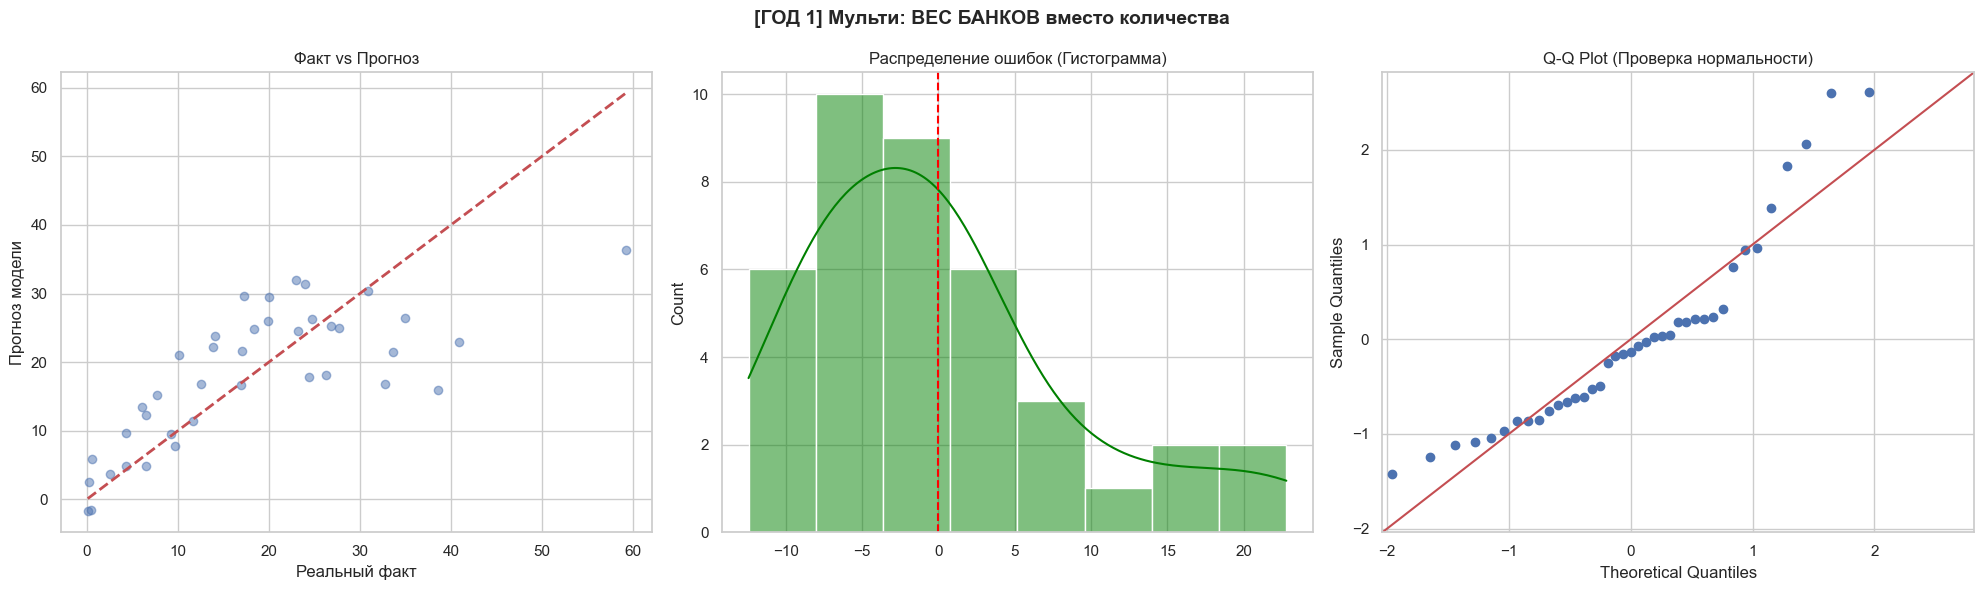


🚀 МОДЕЛЬ: [ГОД 2] Мульти: ВЕС БАНКОВ вместо количества
📌 R-squared (Точность):      0.5065
📌 Adj. R-squared (Честный):  0.4616
📌 F-statistic p-value:       4.2288e-04
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    -8.78718    14.76950     0.55794          ❌
Вес банков (Log площади)      0.08437     0.01788     0.00010        ⭐⭐⭐
Ср. Ключевая ставка           0.54564     0.83905     0.52223          ❌
--------------------------------------------------------------------------------


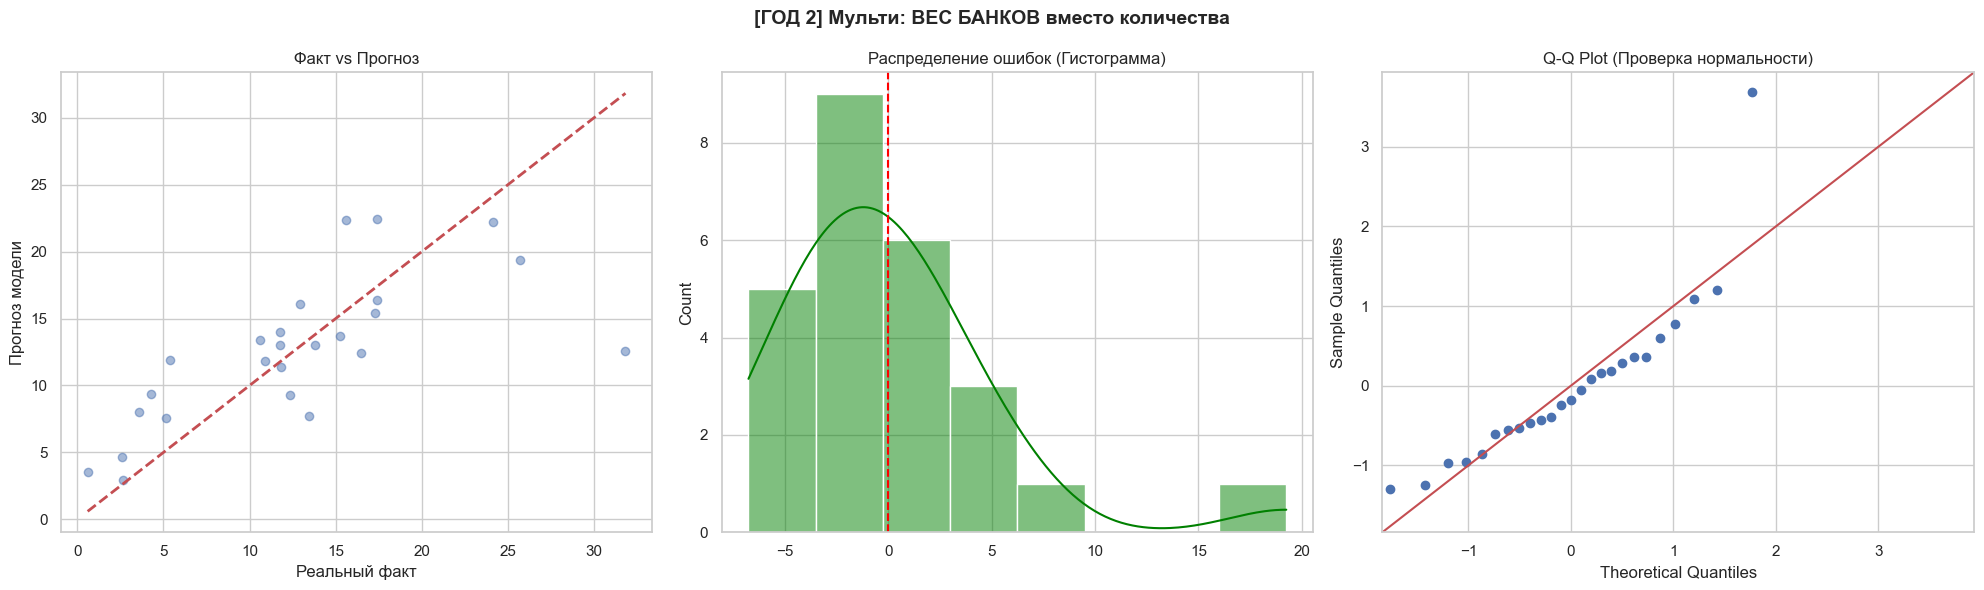

In [52]:
# Заменили кол-во банков на их Вес
features_weighted = ['Bank_Index_Weighted', 'KR_Mean']

# --- ГОД 1 ---
advanced_analysis(df_all, features_weighted, 'Sellout', "Мульти: ВЕС БАНКОВ вместо количества", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_all, features_weighted, 'Sellout', "Мульти: ВЕС БАНКОВ вместо количества", year_filter=2)


🚀 МОДЕЛЬ: [ГОД 1] Мульти: ВЕС БАНКОВ вместо количества
📌 R-squared (Точность):      0.5562
📌 Adj. R-squared (Честный):  0.5442
📌 F-statistic p-value:       5.1000e-08
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    -3.01804     3.39902     0.38032          ❌
Вес банков (Log площади)      0.16106     0.02365     0.00000        ⭐⭐⭐
--------------------------------------------------------------------------------


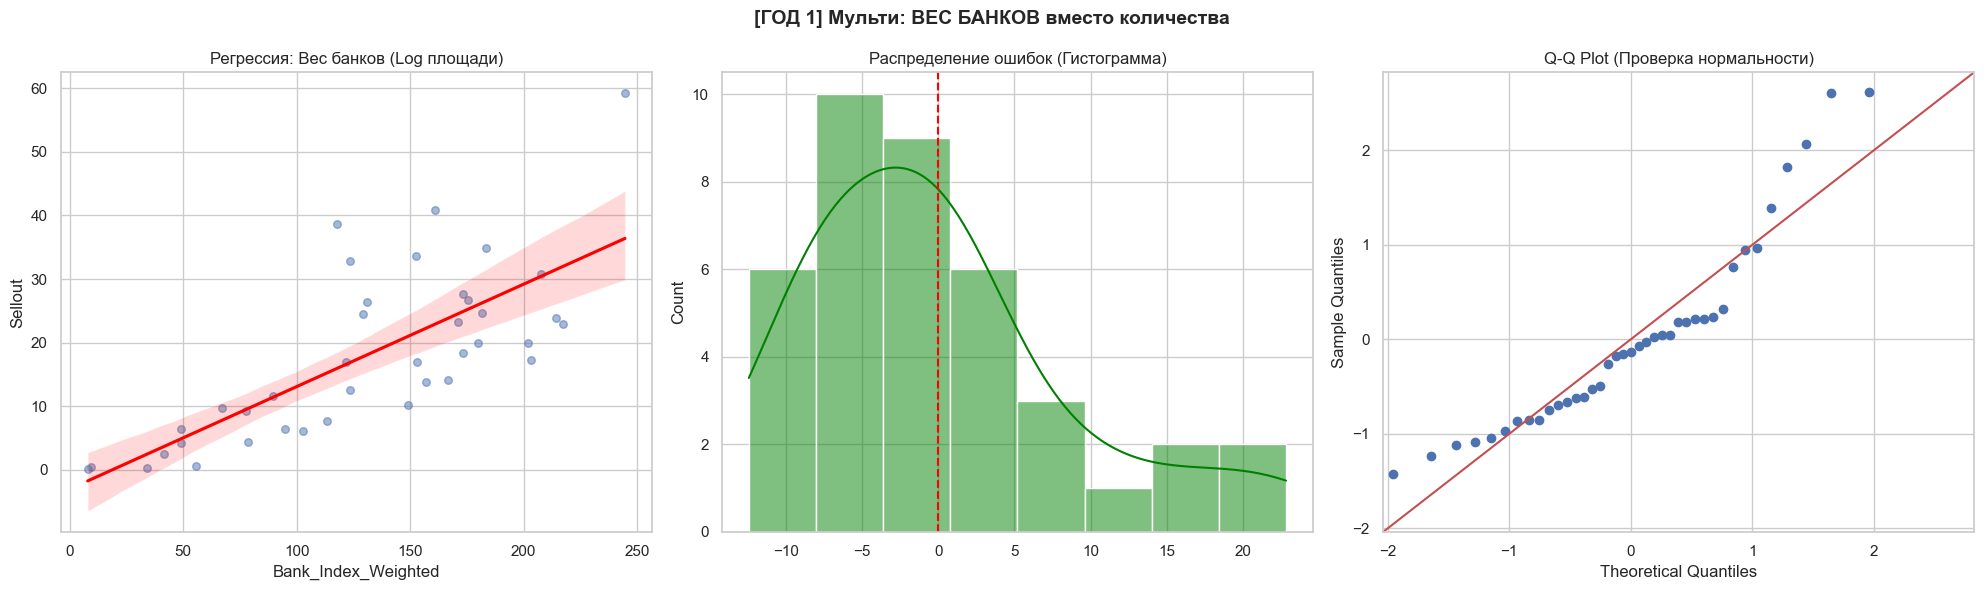


🚀 МОДЕЛЬ: [ГОД 2] Мульти: ВЕС БАНКОВ вместо количества
📌 R-squared (Точность):      0.4970
📌 Adj. R-squared (Честный):  0.4751
📌 F-statistic p-value:       8.3167e-05
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                     0.64706     2.73487     0.81506          ❌
Вес банков (Log площади)      0.08413     0.01765     0.00008        ⭐⭐⭐
--------------------------------------------------------------------------------


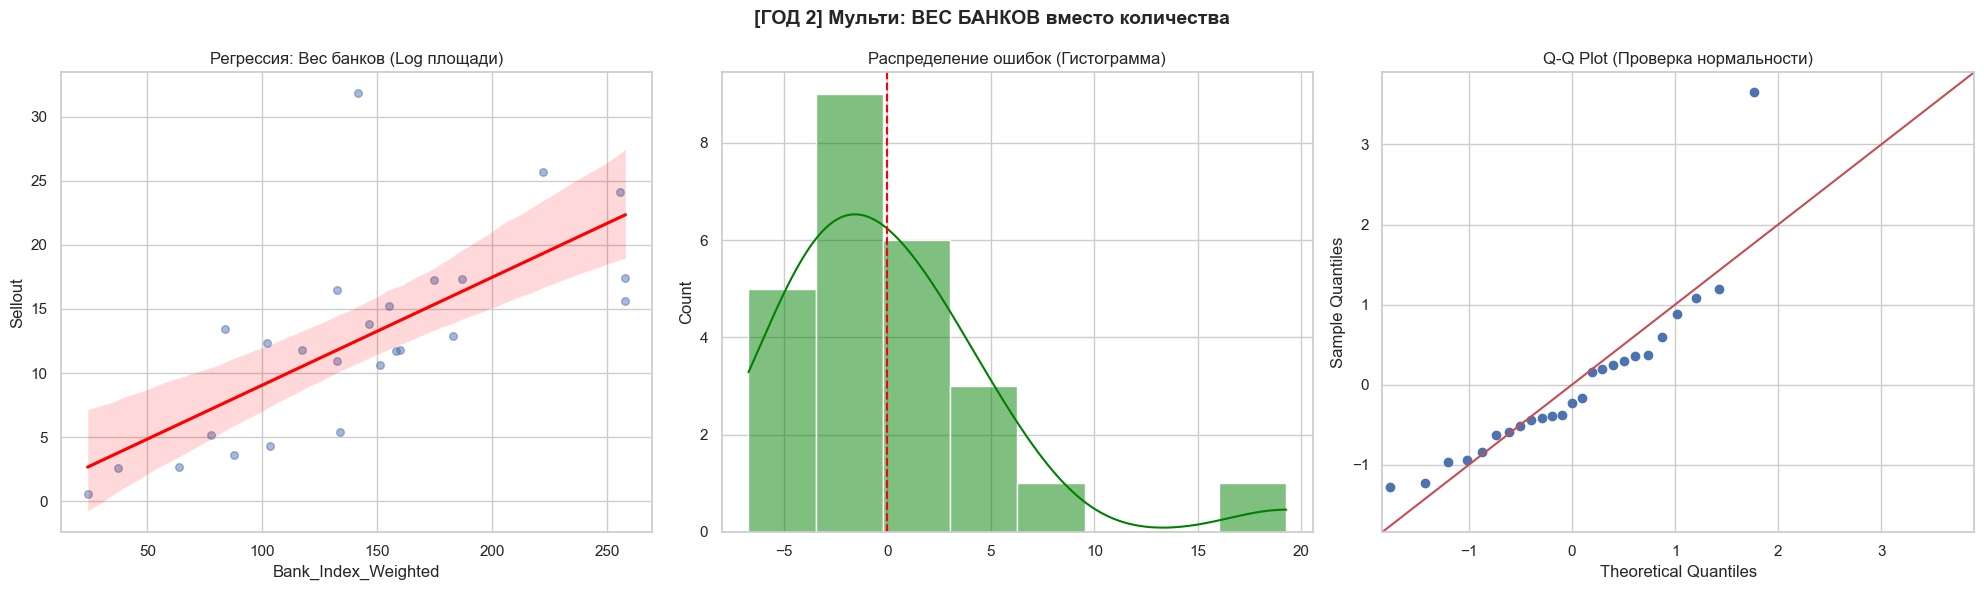

In [56]:
# Заменили кол-во банков на их Вес
features_weighted = ['Bank_Index_Weighted']

# --- ГОД 1 ---
advanced_analysis(df_all, features_weighted, 'Sellout', "Мульти: ВЕС БАНКОВ вместо количества", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_all, features_weighted, 'Sellout', "Мульти: ВЕС БАНКОВ вместо количества", year_filter=2)

🏙️ ПРОВЕРКА НА УСТОЙЧИВОСТЬ: ТОП-3 ОКРУГА (Location Robustness)
🏆 Топ-2 округа по количеству проектов: Коммунарка, Внуково
📊 Строк в выборке (Топ-2): 40

########################################
📅 АНАЛИЗ ЗА ГОД 1
########################################

   📍 ОКРУГ: Коммунарка
      R²: 0.6564 | Проектов: 18
      Влияние (Bank_Index_Weighted): 0.1359 [✅ ЗНАЧИМО, p=0.0010]
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.1262     10.817      0.289      0.777     -19.929      26.182
Bank_Index_Weighted     0.1359      0.033      4.067      0.001       0.065       0.207
KR_Mean                -0.3447      0.599     -0.575      0.574      -1.621       0.932

   📍 ОКРУГ: Внуково
      R²: 0.8880 | Проектов: 7
      Влияние (Bank_Index_Weighted): 0.1124 [✅ ЗНАЧИМО, p=0.0085]
                          coef    std err          t      P>|t|   

<Figure size 1000x600 with 0 Axes>

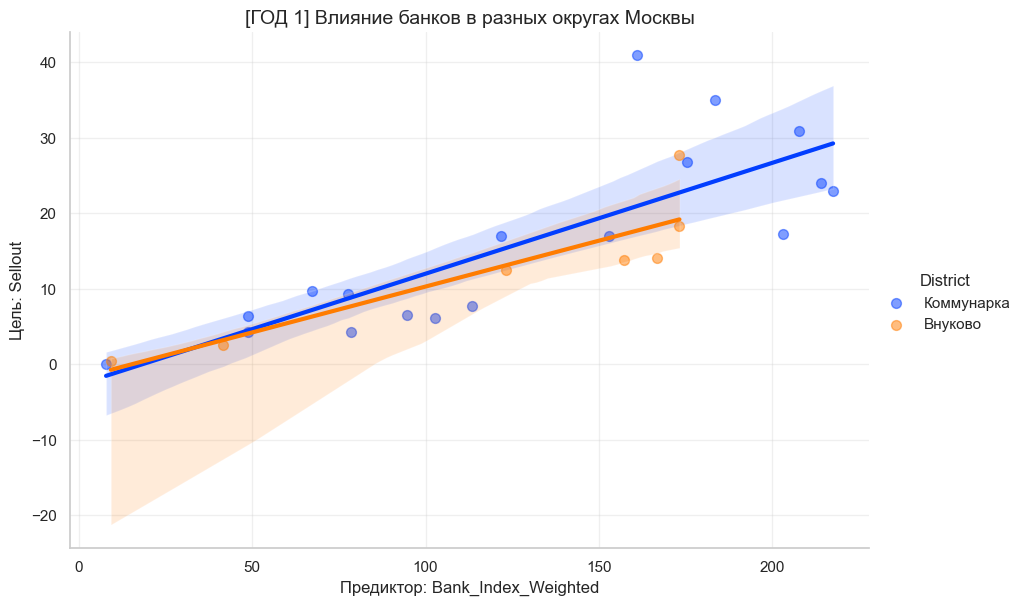


########################################
📅 АНАЛИЗ ЗА ГОД 2
########################################

   📍 ОКРУГ: Коммунарка
      R²: 0.7112 | Проектов: 11
      Влияние (Bank_Index_Weighted): 0.0857 [✅ ЗНАЧИМО, p=0.0112]
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.2749     74.946      0.030      0.977    -170.552     175.102
Bank_Index_Weighted     0.0857      0.026      3.281      0.011       0.025       0.146
KR_Mean                -0.1712      4.120     -0.042      0.968      -9.672       9.329
   ⚠️ Внуково: Слишком мало данных (4 шт.)

   📈 График сравнения округов (Год 2)...


<Figure size 1000x600 with 0 Axes>

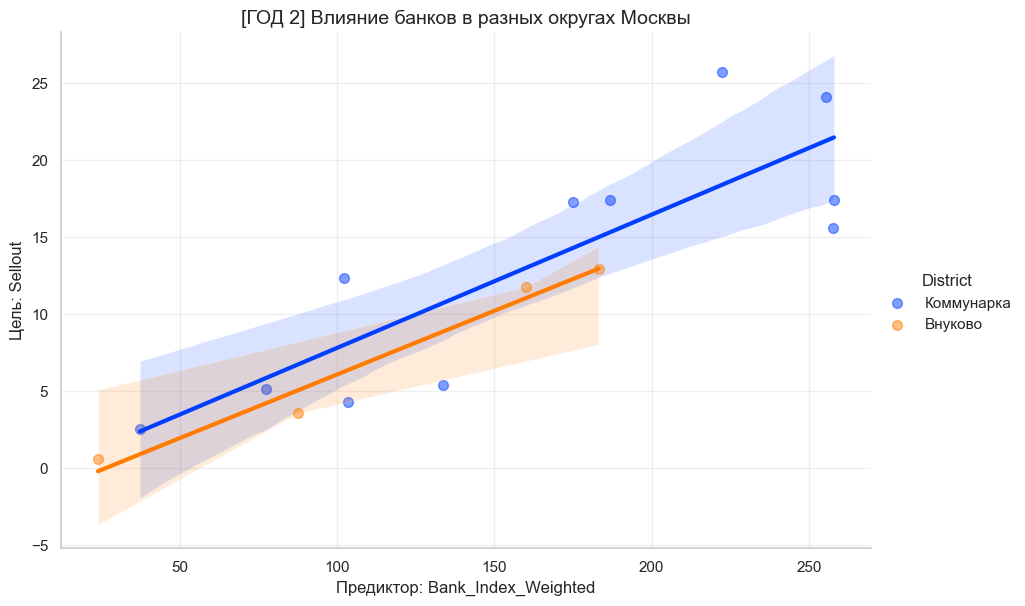

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

def analyze_district_robustness(df_main, path_deals_file, features, target="Sellout"):
    """
    Проверка на устойчивость: Разбиение по Топ-3 Округам.
    1. Подтягивает Округ из raw-файла сделок.
    2. Выбирает 3 округа с наибольшим числом проектов.
    3. Строит модели и сравнивает влияние банков в каждом округе.
    """
    print(f"{'='*80}")
    print("🏙️ ПРОВЕРКА НА УСТОЙЧИВОСТЬ: ТОП-3 ОКРУГА (Location Robustness)")
    print(f"{'='*80}")
    
    # --- ШАГ 1: ПОДТЯГИВАЕМ ОКРУГА ---
    try:
        # Читаем только нужные колонки для скорости
        raw_deals = pd.read_excel(path_deals_file)
        
        # Проверяем название колонки (обычно 'Округ' или 'Административный округ')
        col_district = next((c for c in raw_deals.columns if "округ" in c.lower()), None)
        
        if not col_district:
            print("❌ Ошибка: Не найдена колонка 'Округ' в файле сделок.")
            return

        # Создаем маппинг: Проект -> Округ (берем первый попавшийся, если их несколько)
        # Очистка имен проектов для корректного мерджа
        raw_deals["Проект"] = raw_deals["Название ЖК"].astype(str).str.strip()
        proj_dist_map = raw_deals.groupby("Проект")[col_district].first().reset_index()
        proj_dist_map.columns = ["Project", "District"]
        
        # Мерджим с основным датасетом
        df_geo = df_main.copy()
        df_geo = df_geo.merge(proj_dist_map, on="Project", how="left")
        
    except Exception as e:
        print(f"❌ Ошибка обработки файла сделок: {e}")
        return

    # --- ШАГ 2: ОПРЕДЕЛЯЕМ ТОП-2 ОКРУГА ---
    # Считаем уникальные проекты в каждом округе
    top_districts = df_geo.groupby("District")["Project"].nunique().nlargest(2).index.tolist()
    
    print(f"🏆 Топ-2 округа по количеству проектов: {', '.join(top_districts)}")
    
    # Фильтруем датасет (оставляем только эти 3 округа)
    df_geo = df_geo[df_geo["District"].isin(top_districts)]
    print(f"📊 Строк в выборке (Топ-2): {len(df_geo)}")
    
    # Главная фича для анализа (должна быть первой в списке features)
    main_feature = features[0] 

    # --- ШАГ 3: ЦИКЛ ПО ГОДАМ ---
    for year in [1, 2]:
        print(f"\n{'#'*40}")
        print(f"📅 АНАЛИЗ ЗА ГОД {year}")
        print(f"{'#'*40}")
        
        df_year = df_geo[df_geo["Year_Num"] == year].copy()
        
        if df_year.empty:
            print(f"⚠️ Нет данных для Года {year}")
            continue

        # 3.1 Запуск регрессии для каждого округа
        for dist in top_districts:
            sub_df = df_year[df_year["District"] == dist].dropna(subset=features + [target])
            
            if len(sub_df) < 5:
                print(f"   ⚠️ {dist}: Слишком мало данных ({len(sub_df)} шт.)")
                continue
                
            X = sm.add_constant(sub_df[features])
            y = sub_df[target]
            model = sm.OLS(y, X).fit()
            
            coef = model.params.get(main_feature, 0)
            pval = model.pvalues.get(main_feature, 1)
            signif = "✅ ЗНАЧИМО" if pval < 0.05 else "❌ СЛУЧАЙНО"
            
            print(f"\n   📍 ОКРУГ: {dist}")
            print(f"      R²: {model.rsquared:.4f} | Проектов: {len(sub_df)}")
            print(f"      Влияние ({main_feature}): {coef:.4f} [{signif}, p={pval:.4f}]")
            print(model.summary().tables[1])
            # Если есть другие предикторы, выводим их кратко
            other_feats = [f for f in features if f != main_feature]
            if other_feats:
                sig_others = [f"{f} ({model.params[f]:.2f})" for f in other_feats if model.pvalues[f] < 0.1]
                if sig_others:
                    print(f"      📝 Доп. факторы (p<0.1): {', '.join(sig_others)}")

        # 3.2 ВИЗУАЛИЗАЦИЯ (Сравнение наклона прямых)
        print(f"\n   📈 График сравнения округов (Год {year})...")
        
        plt.figure(figsize=(10, 6))
        sns.lmplot(
            data=df_year, 
            x=main_feature, 
            y=target, 
            hue="District",
            palette="bright", # Яркая палитра для различия
            height=6, 
            aspect=1.5,
            scatter_kws={'alpha': 0.5, 's': 50},
            line_kws={'linewidth': 3}
        )
        
        plt.title(f"[ГОД {year}] Влияние банков в разных округах Москвы", fontsize=14)
        plt.xlabel(f"Предиктор: {main_feature}")
        plt.ylabel(f"Цель: {target}")
        plt.grid(True, alpha=0.3)
        plt.show()

# ==============================================================================
# ЗАПУСК
# ==============================================================================

# 1. Настраиваем список предикторов (МОЖНО МЕНЯТЬ ТУТ)
# Важно: Первым ставь тот фактор, влияние которого хочешь проверить на графике!
features_for_geo = [
    'Bank_Index_Weighted', # <--- Главный проверяемый фактор
    'KR_Mean',              # Контроль масштаба
]

# 2. Запускаем функцию (используем df_all и путь к файлу сделок)
analyze_district_robustness(df_all, FILE_DEALS, features_for_geo, target="Sellout")


################################################################################
📅 АНАЛИЗ ЗА ГОД 1 | Медиана площади: 93,317 м²
################################################################################
🔹 Маленьких проектов: 20
🔹 Больших проектов:   19

📊 --- SMALL (Маленькие) (Многофакторная модель) ---
   R²: 0.7023 | F-pvalue: 3.3647e-05
   🎯 Коэф. Bank_Index_Weighted: 0.1937 [✅ ЗНАЧИМО, p=0.0000]
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.8886      7.669      1.550      0.139      -4.291      28.068
Bank_Index_Weighted     0.1937      0.032      5.982      0.000       0.125       0.262
KR_Mean                -1.1714      0.497     -2.355      0.031      -2.221      -0.122
   📝 Другие значимые факторы (p<0.05):
      • KR_Mean: -1.1714

📊 --- LARGE (Большие) (Многофакторная модель) ---
   R²: 0.6056 | F-pvalue: 5.8594e-

<Figure size 1000x600 with 0 Axes>

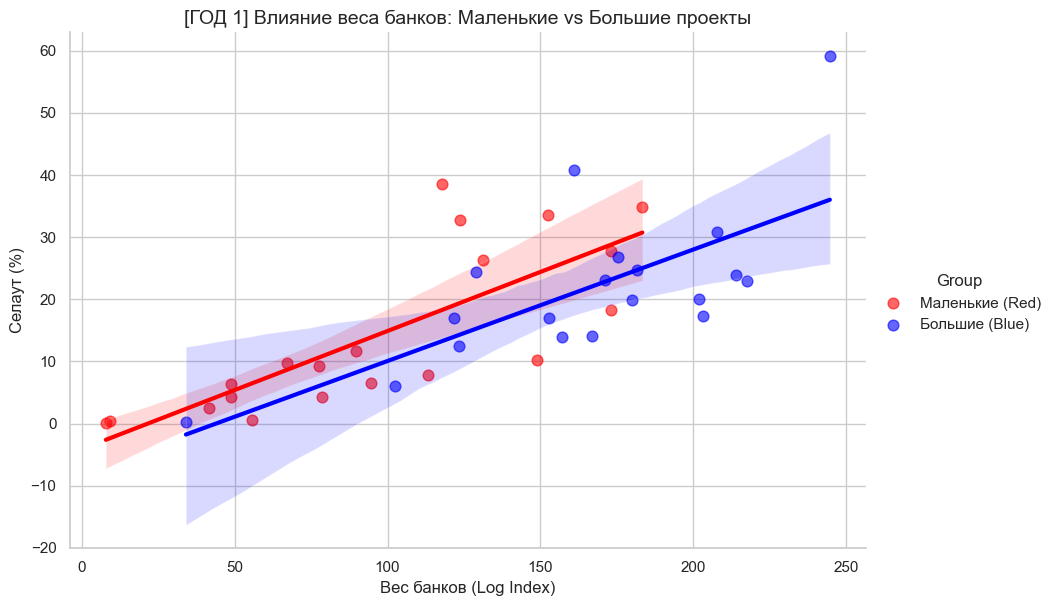


################################################################################
📅 АНАЛИЗ ЗА ГОД 2 | Медиана площади: 180,019 м²
################################################################################
🔹 Маленьких проектов: 13
🔹 Больших проектов:   12

📊 --- SMALL (Маленькие) (Многофакторная модель) ---
   R²: 0.5682 | F-pvalue: 1.5006e-02
   🎯 Коэф. Bank_Index_Weighted: 0.1588 [✅ ЗНАЧИМО, p=0.0050]
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -11.9628     17.153     -0.697      0.501     -50.181      26.256
Bank_Index_Weighted     0.1588      0.044      3.585      0.005       0.060       0.257
KR_Mean                 0.3837      0.963      0.398      0.699      -1.763       2.530
   📝 Другие значимые факторы (p<0.05):
      (нет)

📊 --- LARGE (Большие) (Многофакторная модель) ---
   R²: 0.5306 | F-pvalue: 3.3273e-02
   🎯 Коэф

<Figure size 1000x600 with 0 Axes>

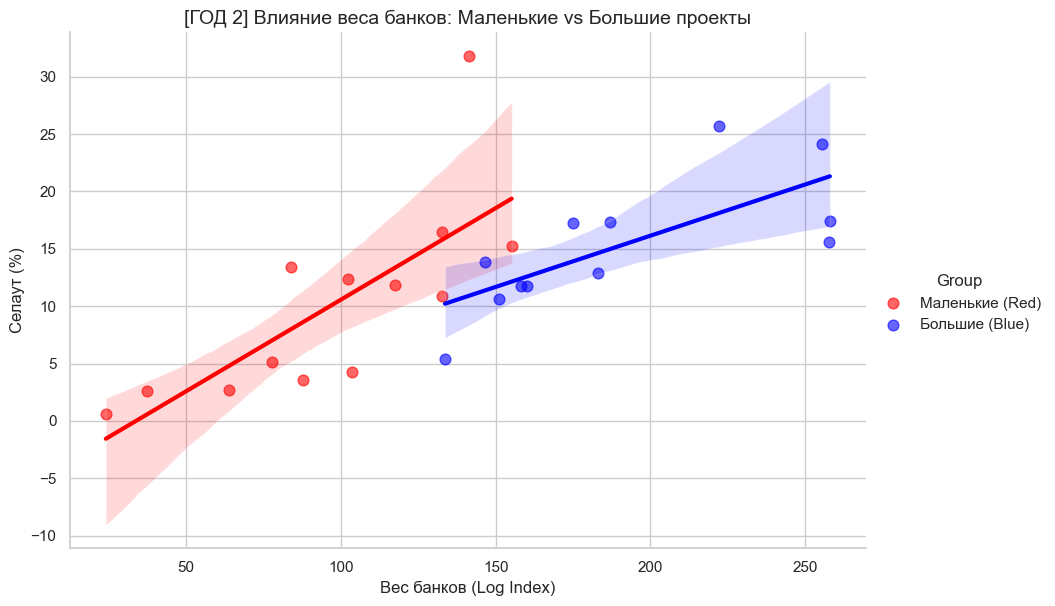

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

def analyze_size_split_by_year(df, features, target="Sellout"):
    """
    Для каждого года (1 и 2):
    1. Делит проекты на Small/Large по медиане площади.
    2. Строит многофакторные модели для каждой группы.
    3. Рисует график сравнения наклона прямых.
    """
    
    # Главная фича для графика (должна быть первой в списке features)
    main_feature = "Bank_Index_Weighted" 
    
    for year in [1, 2]:
        # 1. Фильтруем данные за конкретный год
        df_year = df[df["Year_Num"] == year].copy()
        
        if df_year.empty:
            print(f"⚠️ Нет данных для Года {year}")
            continue
            
        # 2. Считаем медиану и делим
        median_area = df_year["Planned_Area"].median()
        
        df_small = df_year[df_year["Planned_Area"] <= median_area].copy()
        df_large = df_year[df_year["Planned_Area"] > median_area].copy()
        
        # Добавляем метку группы для графика
        df_small["Group"] = "Маленькие (Red)"
        df_large["Group"] = "Большие (Blue)"
        
        print(f"\n{'#'*80}")
        print(f"📅 АНАЛИЗ ЗА ГОД {year} | Медиана площади: {median_area:,.0f} м²")
        print(f"{'#'*80}")
        print(f"🔹 Маленьких проектов: {len(df_small)}")
        print(f"🔹 Больших проектов:   {len(df_large)}")

        # 3. Функция обучения модели (МНОГОФАКТОРНАЯ)
        def run_model(sub_df, group_name):
            # Удаляем пропуски
            sub_df = sub_df.dropna(subset=features + [target])
            X = sm.add_constant(sub_df[features])
            y = sub_df[target]
            model = sm.OLS(y, X).fit()
            
            print(f"\n📊 --- {group_name} (Многофакторная модель) ---")
            print(f"   R²: {model.rsquared:.4f} | F-pvalue: {model.f_pvalue:.4e}")
            
            # Выводим влияние ВЕСА БАНКОВ
            if main_feature in model.params:
                coef = model.params[main_feature]
                pval = model.pvalues[main_feature]
                signif = "✅ ЗНАЧИМО" if pval < 0.05 else "❌ СЛУЧАЙНО"
                print(f"   🎯 Коэф. {main_feature}: {coef:.4f} [{signif}, p={pval:.4f}]")
            print(model.summary().tables[1])
            
            # Выводим остальные значимые факторы (кратко)
            print("   📝 Другие значимые факторы (p<0.05):")
            found = False
            for feat in features:
                if feat != main_feature and model.pvalues[feat] < 0.05:
                    print(f"      • {feat}: {model.params[feat]:.4f}")
                    found = True
            if not found: print("      (нет)")
            
            return model

        # Обучаем модели
        run_model(df_small, "SMALL (Маленькие)")
        run_model(df_large, "LARGE (Большие)")
        
        # 4. ВИЗУАЛИЗАЦИЯ
        print(f"\n📈 ГРАФИК ГОДА {year}: Сравнение трендов")
        
        # Объединяем для рисования
        df_viz = pd.concat([df_small, df_large])
        
        plt.figure(figsize=(10, 6))
        
        # Рисуем линии тренда (lmplot показывает парную корреляцию)
        # Примечание: График показывает "сырую" связь, а статистика выше — очищенную (с контролем других переменных)
        sns.lmplot(
            data=df_viz, 
            x=main_feature, 
            y=target, 
            hue="Group", 
            palette={"Маленькие (Red)": "red", "Большие (Blue)": "blue"},
            height=6, 
            aspect=1.5,
            scatter_kws={'alpha': 0.6, 's': 60},
            line_kws={'linewidth': 3}
        )
        
        plt.title(f"[ГОД {year}] Влияние веса банков: Маленькие vs Большие проекты", fontsize=14)
        plt.xlabel("Вес банков (Log Index)")
        plt.ylabel("Селаут (%)")
        plt.grid(True)
        plt.show()

# ==========================================
# ЗАПУСК
# ==========================================
# Используем df_all (общий датасет)
target_df = df_all if 'df_all' in locals() else df_ml

# Список контрольных переменных
# Важно: Bank_Index_Weighted должен идти ПЕРВЫМ, так как по нему строим график
features_robust = [
    'Bank_Index_Weighted', # <--- Главная
    'KR_Mean',            # Контроль типа сделок
    # Log_Area специально убрали, так как мы разделили выборку по площади
]

analyze_size_split_by_year(target_df, features_robust, "Sellout")